## NuMI Analysis: Nue Smearing

#### Get the smearing matix for nue

First, setup.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward
from collections import defaultdict

main_path = ls.main_path
sys.path.append(main_path)

from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F
from ROOT import gROOT, gBenchmark, gRandom, gSystem

import csv

/home/alex/NuMI/PELEE/
Welcome to JupyROOT 6.24/02


In [2]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

In [3]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [4]:
isRun3 = False

#to use both Run1 and Run3
isCombined = False

ending = "Jan19b"

Now get some data.

In [5]:
import time
s = time.time()

# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
if isRun3 == False and isCombined == False:
    NUE  = '/numi_run1_nue_overlay_fhc'+ls.APPEND
elif isRun3 == True and isCombined == False:
    NUE  = '/numi_run3b_nue_overlay_rhc'+ls.APPEND
elif isCombined == True:
    NUE_R1  = '/numi_run1_nue_overlay_fhc'+ls.APPEND
    NUE_R3  = '/numi_run3b_nue_overlay_rhc'+ls.APPEND


#actually fetch datasets
if isCombined == False:
    nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
elif isCombined == True:
    nue_nue_r1  = uproot.open(ls.ntuple_path+NUE_R1+".root")[ls.fold][tree]
    nue_nue_r3  = uproot.open(ls.ntuple_path+NUE_R3+".root")[ls.fold][tree]

# Define a list that contains the data sets
if isCombined == False:
    uproot_v = [nue_nue]
elif isCombined == True:
    uproot_v = [nue_nue_r1, nue_nue_r3]    

nue_variables = ["run", "sub", "evt", "swtrig_pre",
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction", "proton_e", "elec_e",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

if isCombined == False:
    nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)
elif isCombined == True:
    nue_nue_r1  = nue_nue_r1.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)
    nue_nue_r3  = nue_nue_r3.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

    
#just prints out the time this cell takes
s2 = time.time()
print("")
print ("time to run: ",s2-s)
#run1 = approx 3 mins
#run3 = 
#combined = approx 10 mins

['reco_nu_vtx_sce_z', 'reco_nu_vtx_sce_y', 'slnunhits', 'selected', 'nslice', 'shrsubclusters1', 'shr_distance', 'shr_energy_cali', 'shr_score', 'shr_energy_tot_cali', 'n_tracks', 'shr_py', 'category', 'shr_tkfit_nhits_Y', 'shr_phi', 'slnhits', 'hits_ratio', 'ccnc', 'sub', 'trkshrhitdist2', 'tksh_angle', 'tksh_distance', 'shr_tkfit_nhits_V', 'shrmoliereavg', 'nproton', 'trk_energy', 'reco_nu_vtx_sce_x', 'n_showers', 'topological_score', 'run', 'trk_score_v', 'shr_tkfit_nhits_U', 'evt', 'flash_time', 'shr_tkfit_dedx_U', 'shr_pz', 'proton_e', 'npi0', 'shrsubclusters0', 'trk_energy_tot', 'swtrig_pre', 'contained_fraction', 'nu_pdg', 'shrsubclusters2', 'elec_e', 'npion', 'CosmicIPAll3D', 'shr_tkfit_dedx_Y', 'shr_energy', 'shr_theta', 'n_tracks_contained', 'n_showers_contained', 'shr_tkfit_npoints', 'shr_tkfit_dedx_V', 'shr_px']

time to run:  33.249412059783936


The following cell allows us to reload original data event weights. No weights have been added to data or ext so these are not included.

In [6]:
if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]

In [7]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
#df_v = [nue_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    
#BDT

In [8]:
# Let's calculate the weights that we need to apply to the individual MC events 
# to become our best model of the NuMI data. 
# This cell calculates the GENIE Tune * PPFX correction to the MC weights and 
# cleans up extremely high (or low) weight scores (may be due to computational errors).
# The clean up is not the best practice (one should dig and understand why the weight are big/negative): 
# it's a cheat until we figure out the next best thing. Life is not perfect and your analysis won't be either. Please enojy LArbys

constructNuMISys = True

if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]

# We need to do this only for the MC samples (all data events weight = 1)
#df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

#BDT

Get Log Likelihood Ratio Particle ID for track candidates. Will need proton for nue, muon for numu.

In [9]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [10]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [11]:
#TRUTH VARIABLE

import time
s = time.time()

for i,df in enumerate(df_v):
    df["elec_px_asmuon"] = np.nan
    df["elec_py_asmuon"] = np.nan
    df["elec_pz_asmuon"] = np.nan
    for j in range(len(df["mc_pdg"])):
        pdg_vector = df["mc_pdg"].iloc[j][0]
        px_vector = df["mc_px"].iloc[j]
        py_vector = df["mc_py"].iloc[j]
        pz_vector = df["mc_pz"].iloc[j]
        result = np.where(pdg_vector==11)[0]
        if np.size(result):
            df.loc[j, "elec_px_asmuon"] = px_vector[result][0]
            df.loc[j, "elec_py_asmuon"] = py_vector[result][0]
            df.loc[j, "elec_pz_asmuon"] = pz_vector[result][0]
            
    print(df["elec_px_asmuon"])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

entry
0        -0.067197
1         0.420124
2              NaN
3         0.073929
4              NaN
            ...   
127758   -0.064556
127759    0.073235
127760    0.413107
127761   -0.171186
127762         NaN
Name: elec_px_asmuon, Length: 127763, dtype: float64
time to run:  118.14714574813843


In [12]:
#TRUTH_VARIABLE

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [13]:
#RECO VARIABLE
#This assumes the electron to be the leading shower
import time
s = time.time()

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon_reco']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon_reco'] = np.arccos(df['shr_pz']/df['targetP_asmuon_reco'] )
    #df['targetPhi_asmuon_reco']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  6.387488603591919


In [14]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
#df_v = [nue_nue]

if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

#BDT

time to run:  16.97042965888977


In [15]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [16]:
#df_v = [nue_nue]
if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]
    
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']


In [17]:
if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]


# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [18]:
 #########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
#df_v = [nue_nue]
if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]

for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304  

In [19]:
# Some quick clean up since some strange events get in there
if isCombined == False:
    nue_nue  = nue_nue.query('nu_e > 0.')
    dfmc_v = [nue_nue]
elif isCombined == True:
    nue_nue_r1  = nue_nue_r1.query('nu_e > 0.')
    nue_nue_r3  = nue_nue_r3.query('nu_e > 0.')
    dfmc_v = [nue_nue_r1, nue_nue_r3]

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
#dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    


## BDT

In [20]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'


In [21]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model_r1 = xgb.Booster({'nthread': 4})
bdt_model_r3 = xgb.Booster({'nthread': 4})

if isRun3 == False and isCombined==False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True and isCombined==False:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model') 
elif isCombined == True:
    bdt_model_r1.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
    bdt_model_r3.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model') 

In [22]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

if isCombined == False:
    datasetlist = [nue_nue]
elif isCombined == True:
    datasetlist = [nue_nue_r1, nue_nue_r3]

count = 0
for df in datasetlist:
    count = count +1
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])

    # apply the bdt selection
    if isCombined==True and count==1:
        preds = bdt_model_r1.predict(df_test)
    elif isCombined==True and count==2:
        preds = bdt_model_r3.predict(df_test)
    else:
        preds = bdt_model.predict(df_test)
        
        
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(127763, 133)


In [23]:
if isCombined == False:
    datasets_bdt = nue_nue
elif isCombined == True:
    datasets_bdt_r1 = nue_nue_r1
    datasets_bdt_r3 = nue_nue_r3

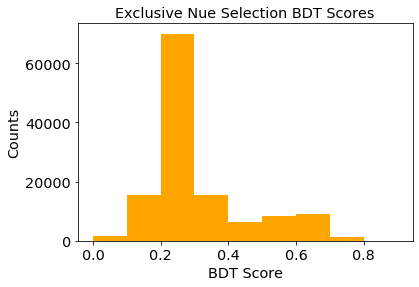

In [24]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
if isCombined == True:
    gen = plt.hist(datasets_bdt_r1['BDT_score'], bins, color='orange')
    gen2 = plt.hist(datasets_bdt_r3['BDT_score'], bins, color='blue')
elif isCombined == False:
    gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [25]:
if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]
    
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
            

In [26]:
###Need to use the same BDT split value Katerina did

SEL_QUERY = BDT_LOOSE_CUTS

if isCombined == True:
    SEL_QUERY_R1 = SEL_QUERY + ' and BDT_score > 0.55' 
    SEL_QUERY_R3 = SEL_QUERY + ' and BDT_score > 0.575'     

    SIGNAL_NUE_SEL_QUERY_R1 = SEL_QUERY_R1
    SIGNAL_NUE_SEL_QUERY_R1 += 'and is_signal==True'
    SIGNAL_NUE_SEL_QUERY_R3 = SEL_QUERY_R3
    SIGNAL_NUE_SEL_QUERY_R3 += 'and is_signal==True'
else:
    if isRun3 == False:
        SEL_QUERY += ' and BDT_score > 0.55' 
    elif isRun3 == True:
        SEL_QUERY += ' and BDT_score > 0.575'     

    SIGNAL_NUE_SEL_QUERY = SEL_QUERY
    SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [27]:
#New categories

for i,df in enumerate(df_v):
            
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [28]:
for i,df in enumerate(df_v):
    #ANGLE
    tmp = df["cosNu_Angle_Numi_Elec_asmuon"].copy()
    mask = (df["cosNu_Angle_Numi_Elec_asmuon"] > 1)
    tmp[mask] = 0.9
    df["cosNu_Angle_Numi_Elec_asmuon"] = tmp
    print(df["cosNu_Angle_Numi_Elec_asmuon"])
    #------
    tmp = df["cosNu_Angle_Numi_Elec_asmuon"].copy()
    mask = (df["cosNu_Angle_Numi_Elec_asmuon"] < -1)
    tmp[mask] = -0.9
    df["cosNu_Angle_Numi_Elec_asmuon"] = tmp
    print(df["cosNu_Angle_Numi_Elec_asmuon"])

entry
0         0.845160
1         0.919119
2              NaN
3         0.902700
4              NaN
            ...   
127758    0.737878
127759   -0.495729
127760    0.901225
127761    0.201647
127762         NaN
Name: cosNu_Angle_Numi_Elec_asmuon, Length: 127763, dtype: float64
entry
0         0.845160
1         0.919119
2              NaN
3         0.902700
4              NaN
            ...   
127758    0.737878
127759   -0.495729
127760    0.901225
127761    0.201647
127762         NaN
Name: cosNu_Angle_Numi_Elec_asmuon, Length: 127763, dtype: float64


In [29]:
for i,df in enumerate(df_v):
    #ANGLE
    tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
    mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] > 1)
    tmp[mask] = 0.9
    df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
    print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])
    #------
    tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
    mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] < -1)
    tmp[mask] = -0.9
    df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
    print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])
    

entry
0        -0.906756
1         0.923636
2         0.987200
3         0.911294
4         0.836977
            ...   
127758    0.726773
127759    0.973092
127760    0.974229
127761   -0.906756
127762    0.977648
Name: cosNu_Angle_Numi_Elec_asmuon_reco, Length: 127763, dtype: float64
entry
0        -0.906756
1         0.923636
2         0.987200
3         0.911294
4         0.836977
            ...   
127758    0.726773
127759    0.973092
127760    0.974229
127761   -0.906756
127762    0.977648
Name: cosNu_Angle_Numi_Elec_asmuon_reco, Length: 127763, dtype: float64


## Smearing with Weights test

n_events here =  127763

1.0
1
{'nue_nue': 0.008396975409457512}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.55and is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.6741389  0.8776034  0.83227533 ... 1.0469182  0.967728   0.90734977]
current_total  53.65730794901259
53.657307949012590597703820094466209411621093750000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  53.65730794901259
53.6573079490125905977038200944662094116210937500000000000

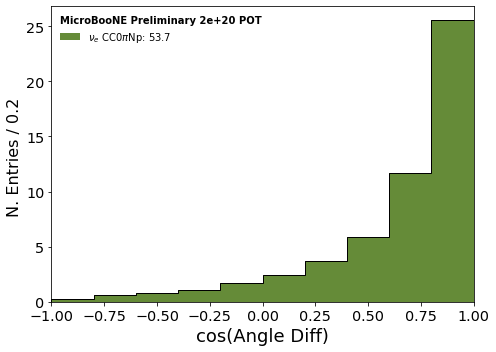

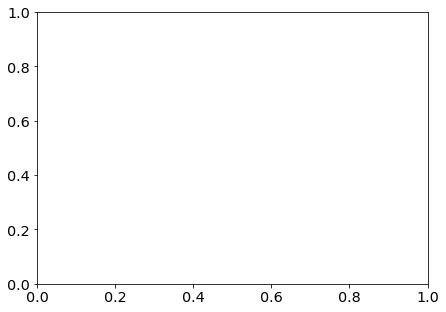

In [30]:
##THE TRUTH
if isCombined == False:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue.shape[0]
    print("n_events here = ", n_events)
    print("")
    #batch_size = 40000
    batch_size = n_events
    varss1 = []
    weightss1 = []
    labss1 = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        if isRun3 == False:
            pot =  2e+20 
            nueratio  = pot/2.38181e+22 
        elif isRun3 == True:
            pot =  5.014e20
            nueratio  = pot/2.53486e+22 

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
       

        var1, weight1, label1 = my_plotter.plot_variable(
            VARIABLE,
            query= SIGNAL_NUE_SEL_QUERY,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss1.append(var1)
        weightss1.append(weight1)
        labss1.append(label1)

n_events here =  127763
n_events/2 here =  102210.0

1.0
1
{'nue_nue': 0.008396975409457512}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.55and is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.6741389  0.8776034  0.83227533 ... 1.0469182  0.967728   0.90734977]
current_total  53.65730794901259
53.657307949012590597703820094466209411621093750000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  53.65730794901259
53.657307949012590597703820094

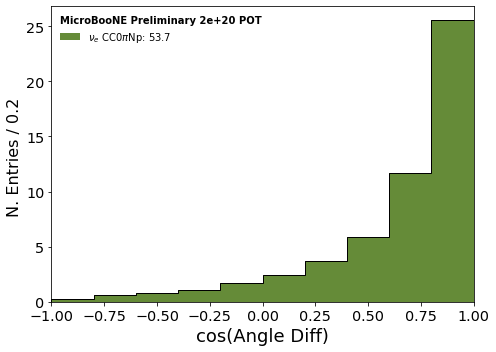

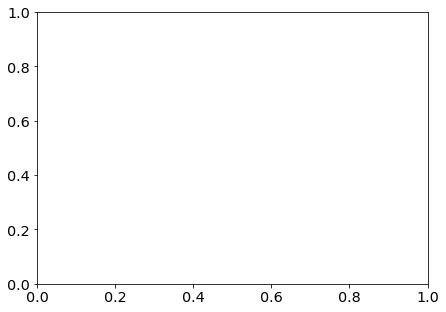

In [32]:
if isCombined == True:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue_r1.shape[0]
    print("n_events here = ", n_events)
    print("n_events/2 here = ", np.floor(n_events/1.25))
    print("")
    #batch_size = 40000
    batch_size = n_events
    #batch_size = int(np.floor(n_events/1.25))
    #n_events = batch_size

    varss1 = []
    weightss1 = []
    labss1 = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue_r1.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
        

        var1, weight1, label1 = my_plotter.plot_variable(
            VARIABLE,
            query= SIGNAL_NUE_SEL_QUERY_R1,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss1.append(var1)
        weightss1.append(weight1)
        labss1.append(label1)

n_events here =  124428

1.0
1
{'nue_nue': 0.019780185098979827}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575and is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.88565   0.5846971 0.9407419 ... 1.1434569 1.0834242 1.0868943]
current_total  101.60557700164077
101.605577001640767775825224816799163818359375000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  101.60557700164077
101.60557700164076777582522481679916381835937500000000000000

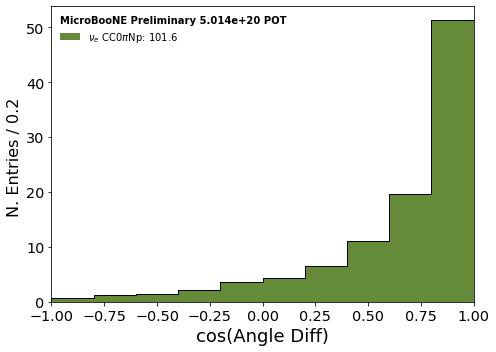

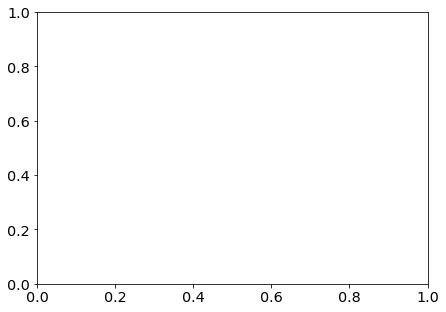

In [33]:
if isCombined == True:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue_r3.shape[0]
    print("n_events here = ", n_events)
    print("")
    #batch_size = 40000
    batch_size = n_events
    #batch_size = int(np.floor(n_events/1.25))
    #n_events = batch_size

    varss1b = []
    weightss1b = []
    labss1b = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue_r3.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        pot =  5.014e20
        nueratio  = pot/2.53486e+22 

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
        

        var1, weight1, label1 = my_plotter.plot_variable(
            VARIABLE,
            query= SIGNAL_NUE_SEL_QUERY_R3,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss1b.append(var1)
        weightss1b.append(weight1)
        labss1b.append(label1)

No handles with labels found to put in legend.


(array([ 0.28087452,  0.64423728,  0.82202069,  1.04083513,  1.71289207,
        2.4057081 ,  3.66690833,  5.85479241, 11.70391501, 25.5251244 ]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]), <a list of 10 Patch objects>)
(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]), <a list of 10 Patch objects>)


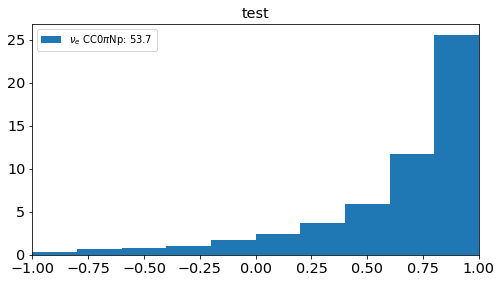

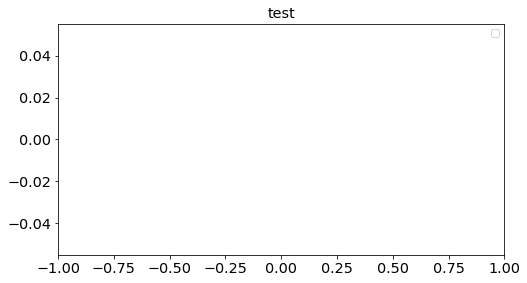

In [31]:

from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss1[i].values(),
                weights=list(weightss1[i].values()),
                stacked=True,
                label=labss1[i],
                bins=BINS,
                range=RANGE)

    plt.title("test")
    plt.legend()

    print(nue_stacked)

No handles with labels found to put in legend.


(array([ 0.60972852,  1.27631838,  1.35168266,  2.08123357,  3.54398341,
        4.39671192,  6.44349808, 11.04464022, 19.59088687, 51.26689338]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]), <a list of 10 Patch objects>)
(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]), <a list of 10 Patch objects>)


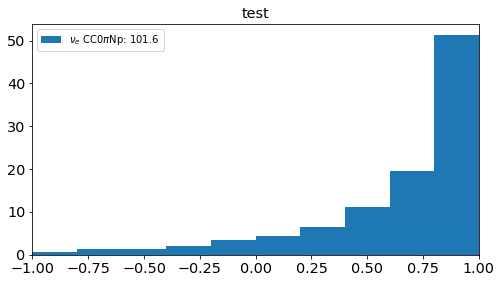

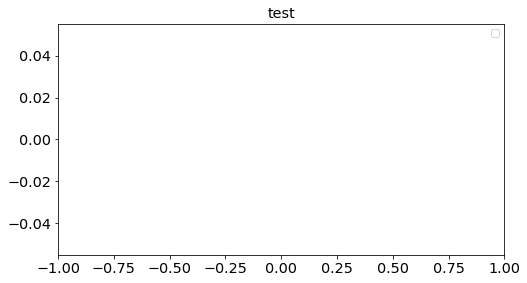

In [35]:
if isCombined == True:
    from matplotlib import gridspec

    for i in range(int(n_events/batch_size)+1):
        nue_fig = plt.figure(figsize=(8, 7))
        nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
        nue_ax1 = plt.subplot(nue_gs[0])
        #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
        nue_ax1.set_xlim([-1, 1])    #AngleDiff

        nue_stacked = nue_ax1.hist(
                    varss1b[i].values(),
                    weights=list(weightss1b[i].values()),
                    stacked=True,
                    label=labss1b[i],
                    bins=BINS,
                    range=RANGE)

        plt.title("test")
        plt.legend()

        print(nue_stacked)

0.2808745238078685


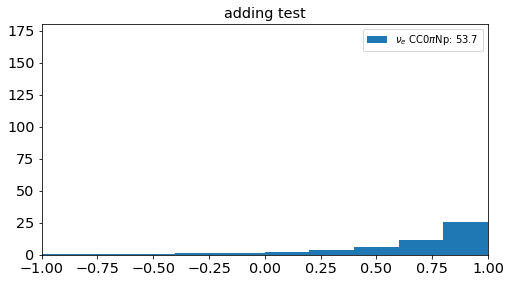

In [32]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    

if isCombined == False:
    varss_tot = combine_dicts(varss1)
    weightss_tot = combine_dicts(weightss1)
elif isCombined == True:
    varss_temp = varss1 + varss1b
    weightss_temp = weightss1 + weightss1b
    varss_tot = combine_dicts(varss_temp)
    weightss_tot = combine_dicts(weightss_temp)

category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}



labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss1[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 160])
#nue_ax1.set_ylim([0, 40])

#AngleDiff
nue_ax1.set_xlim([-1, 1])
nue_ax1.set_ylim([0, 180])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

print(nue_stacked[0][0])

temp_truth_sig = nue_stacked[0][0]
#print('%.50f' % math.fsum(temp_truth_sig))

In [33]:
signal_nue_selected = temp_truth_sig
print("signal_nue_selected ", signal_nue_selected)

signal_nue_selected  0.2808745238078685


In [34]:
####################################################################

n_events here =  127763
n_events/2 here =  102210.0

1.0
1
{'nue_nue': 0.008396975409457512}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.55and is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.6741389  0.8776034  0.83227533 ... 1.0469182  0.967728   0.90734977]
current_total  53.65730794901259
53.657307949012590597703820094466209411621093750000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  53.65730794901259
53.657307949012590597703820094

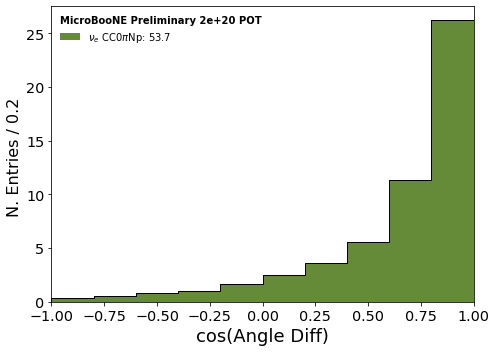

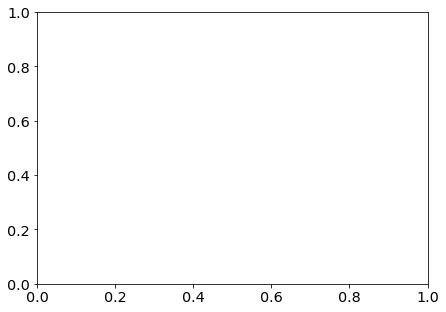

In [35]:
# NOW WITH RECO SELECTION

if isCombined == False:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue.shape[0]
    print("n_events here = ", n_events)
    print("n_events/2 here = ", np.floor(n_events/1.25))
    print("")
    batch_size = n_events

    varss2 = []
    weightss2 = []
    labss2 = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        if isRun3 == False:
            pot =  2e+20 
            nueratio  = pot/2.38181e+22 
        elif isRun3 == True:
            pot =  5.014e20
            nueratio  = pot/2.53486e+22 

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
        

        var2, weight2, label2 = my_plotter.plot_variable(
            VARIABLE,
            query= SIGNAL_NUE_SEL_QUERY,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss2.append(var2)
        weightss2.append(weight2)
        labss2.append(label2)

n_events here =  127763
n_events/2 here =  102210.0

1.0
1
{'nue_nue': 0.008396975409457512}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.55and is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.6741389  0.8776034  0.83227533 ... 1.0469182  0.967728   0.90734977]
current_total  53.65730794901259
53.657307949012590597703820094466209411621093750000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  53.65730794901259
53.657307949012590597703820094

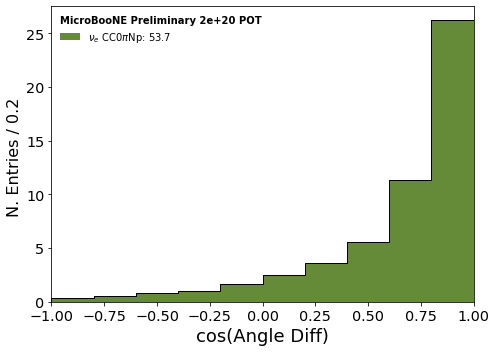

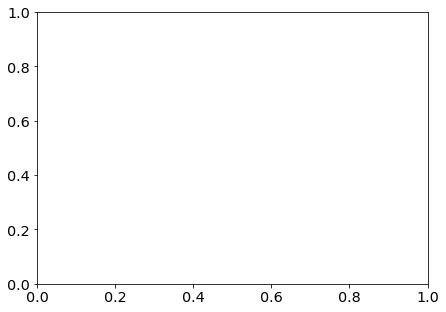

In [39]:
# NOW WITH RECO SELECTION

if isCombined == True:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue_r1.shape[0]
    print("n_events here = ", n_events)
    print("n_events/2 here = ", np.floor(n_events/1.25))
    print("")
    #batch_size = 40000
    batch_size = n_events
    #batch_size = int(np.floor(n_events/1.25))
    #n_events = batch_size

    varss2 = []
    weightss2 = []
    labss2 = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue_r1.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
        

        var2, weight2, label2 = my_plotter.plot_variable(
            VARIABLE,
            query= SIGNAL_NUE_SEL_QUERY_R1,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss2.append(var2)
        weightss2.append(weight2)
        labss2.append(label2)

n_events here =  124428
n_events/2 here =  99542.0

1.0
1
{'nue_nue': 0.019780185098979827}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575and is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.88565   0.5846971 0.9407419 ... 1.1434569 1.0834242 1.0868943]
current_total  101.60557700164077
101.605577001640767775825224816799163818359375000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  101.60557700164077
101.60557700164076777582522481679

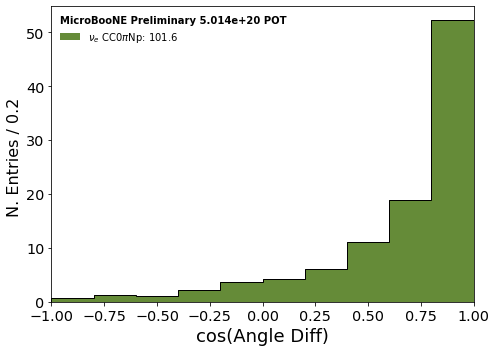

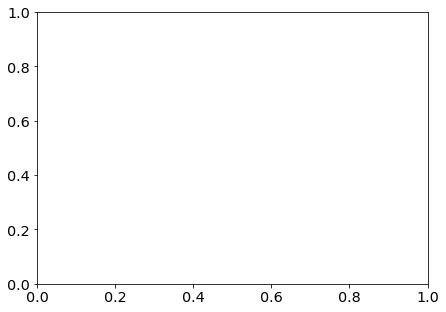

In [40]:
if isCombined == True:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue_r3.shape[0]
    print("n_events here = ", n_events)
    print("n_events/2 here = ", np.floor(n_events/1.25))
    print("")
    #batch_size = 40000
    batch_size = n_events
    #batch_size = int(np.floor(n_events/1.25))
    #n_events = batch_size

    varss2b = []
    weightss2b = []
    labss2b = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue_r3.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        pot =  5.014e20
        nueratio  = pot/2.53486e+22

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
        

        var2, weight2, label2 = my_plotter.plot_variable(
            VARIABLE,
            query= SIGNAL_NUE_SEL_QUERY_R3,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss2b.append(var2)
        weightss2b.append(weight2)
        labss2b.append(label2)

No handles with labels found to put in legend.


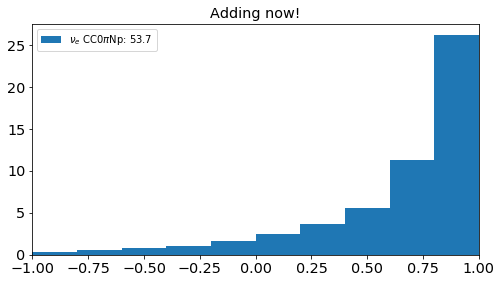

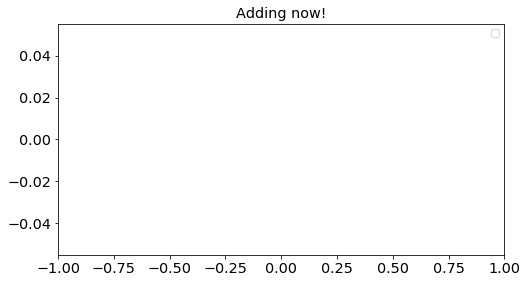

In [36]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss2[i].values(),
                weights=list(weightss2[i].values()),
                stacked=True,
                label=labss2[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

No handles with labels found to put in legend.


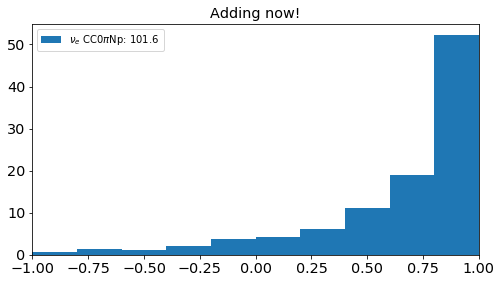

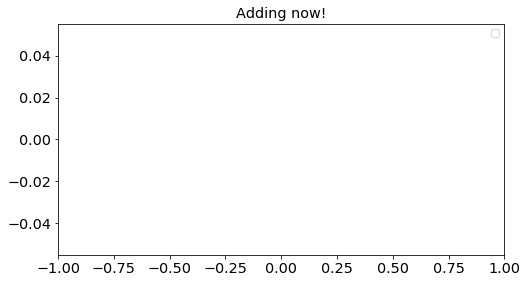

In [42]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss2b[i].values(),
                weights=list(weightss2b[i].values()),
                stacked=True,
                label=labss2b[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()
    

0.3260811352457425


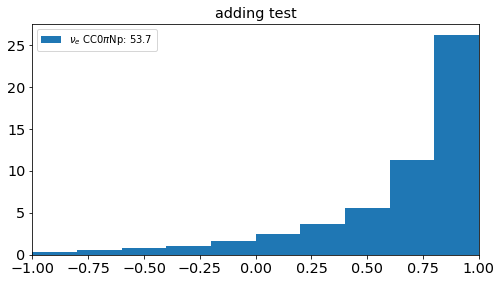

In [37]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    

if isCombined == False:
    varss_tot = combine_dicts(varss2)
    weightss_tot = combine_dicts(weightss2)
elif isCombined == True:
    varss_temp = varss2 + varss2b
    weightss_temp = weightss2 + weightss2b
    varss_tot = combine_dicts(varss_temp)
    weightss_tot = combine_dicts(weightss_temp)

category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}



labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss1[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])


#AngleDiff
nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 180])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

print(nue_stacked[0][0])

temp_truth_sig = nue_stacked[0][0]

In [38]:
#########################################################

In [39]:
# plot the smearing matrix 
def plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(var1, var2,
                   bins, weights=weight1, cmin=0.000000001, cmap='OrRd')
    
    sel1 = plt.hist(var1, bins, weights=weight1, color='white')
    print("sel1 = ", sel1[0])
    print("sum sel1 = ", math.fsum(sel1[0]))
    print("")
    sel2 = plt.hist(var2, bins, weights=weight2, color='white')
    print("sel2 = ", sel2[0])
    print("sum sel2 = ", math.fsum(sel2[0]))
    print("")
    print("truth - reco (sel1 - sel2) ")
    print(sel1[0] - sel2[0])
    print(math.fsum(sel1[0]) - math.fsum(sel2[0]))
    
    zero_copy_smear = np.copy(smear[0].T)
    
    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if np.isnan(zero_copy_smear[i,j]):
                zero_copy_smear[i,j]= 0

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)
        
    print("---------------------------------------------------------")

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
        
        gen = plt.hist(var3, bins, weights=weight3, color='deepskyblue')
        print("")
        print("GENERATED")
        print(gen[0])
        print("")
        plt.close()
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            #reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            #tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1):
                norm_array[i][j] =  norm_array[i][j] / gen[0][j]
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
        
        zero_copy_smear_norm = np.copy(norm_array)

        for i in range(len(bins)-1): # reco bins i (y axis) rows
            for j in range(len(bins)-1): # true bins j (x axis) cols
                if np.isnan(zero_copy_smear_norm[i,j]):
                    zero_copy_smear_norm[i,j]= 0

        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)
        
        if isRun3==False and isCombined == False:
            print("isRun3==False and isCombined == False")
            #WHOOPS, overwrote 3dp if needed again....
            np.savetxt("nue_full_500_catsel_nopions_angleDiff_usingSelection_smearcept_weighted_recoCut_"+ending+".csv", 
               zero_copy_smear_norm,
               delimiter =", ", 
               fmt ='% s')
            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)

            """
            #with open('nue_full_500_catsel_nopions_angleDiff_usingSelection_prior_true_signal_recoCut_run1_'+ending+'.csv') as file:
            #    content = file.readlines()
            #prior_true = content[0:]

            #for i in range(10):
            #    prior_true[i]=prior_true[i].rstrip().rstrip(',')
            #    prior_true[i] = float(prior_true[i])
            prior_true = pd.read_csv('nue_full_500_catsel_nopions_angleDiff_usingSelection_prior_true_signal_recoCut_run1_'+ending+'.csv', header=None)

            prior_true = prior_true.values[:, 0]
            
            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            #with open('nue_full_500_catsel_nopions_angleDiff_usingSelection_data_signal_MCONLY_recoCut_'+ending+'.csv') as file:
            #    content = file.readlines()
            #mcsig = content[0:]

            #for i in range(10):
            #    mcsig[i]=mcsig[i].rstrip().rstrip(',')
            #    mcsig[i] = float(mcsig[i])
            mcsig = pd.read_csv(nue_full_500_catsel_nopions_angleDiff_usingSelection_data_signal_MCONLY_recoCut_'+ending+'.csv', header=None)

            mcsig = mcsig.values[:, 0]
            

            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])
            """
            #print(diffs)
        elif isRun3==True and isCombined == False:
            print("isRun3==True and isCombined == False")
            np.savetxt("nue_full_500_catsel_nopions_angleDiff_usingSelection_smearcept_weighted_recoCut_run3_"+ending+".csv", 
               zero_copy_smear_norm,
               delimiter =", ", 
               fmt ='% s')
            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)
            """

            with open('nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_run3_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(10):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('nue_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY_recoCut_run3_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(10):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])

            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])
            """
            #print(diffs)

        elif isCombined == True:
            np.savetxt("nue_full_500_catsel_nopions_angleDiff_usingSelection_smearcept_weighted_recoCut_comb_"+ending+".csv", 
               zero_copy_smear_norm,
               delimiter =", ", 
               fmt ='% s')
            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)

            """
            with open('nue_full_500_catsel_nopions_angleDiff_usingSelection_prior_true_signal_recoCut_comb_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(10):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('nue_full_500_catsel_nopions_angleDiff_usingSelection_data_signal_MCONLY_recoCut_comb_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(10):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])

            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])

            #print(diffs)
            """
        
        
    plt.xlabel('cos(True Lepton Angle)', fontsize=15)
    plt.ylabel('cos(Reco Lepton Angle)', fontsize=15)
    #plt.text(0.1, 4.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()
    fig.savefig("nue_full_500_catsel_nopions_angleDiff_usingSelection_smearcept_weighted_recoCut_comb_"+ending+".svg",bbox_inches='tight' )
    
    if norm:
        return zero_copy_smear_norm
    else:
        return zero_copy_smear

In [40]:
def _selection(variable, sample, query="selected==1", extra_cut=None, track_cuts=None, select_longest=True):
        '''
        variable,  must be specified
        select_longest, True by default, keeps from multiple tracks of same event making it through
        query must be a string defining event-level cuts
        track_cuts is a list of cuts of which each entry looks like
            (variable_tobe_cut_on, '>'or'<'or'=='etc, cut value )
            or
            (variable, [operator1, operator2], [cutval1, cutval2]) to do an 'or' cut
        track_
        returns an Series of values that pass all track_cuts
        '''
        sel_query = query
        if extra_cut is not None:
            sel_query += "& %s" % extra_cut
        '''
        if ( (track_cuts == None) or (select_longest == False) ):
            return sample.query(sel_query).eval(variable).ravel()
        '''


        '''
        df = sample.query(sel_query)
        #print (df.isna().sum())
        dfna = df.isna()
        for (colname,colvals) in dfna.iteritems():
            if (colvals.sum() != 0):
                print ('name : ',colname)
                print ('nan entries : ',colvals.sum())
        '''  
        df = sample.query(sel_query)
        
        #if (track_cuts != None):
        #    df = sample.query(sel_query).dropna().copy() #don't want to eliminate anything from memory

        #df = sample.query(sel_query).dropna().copy() #don't want to eliminate anything from memory

        track_cuts_mask = None #df['trk_score_v'].apply(lambda x: x == x) #all-True mask, assuming trk_score_v is available
        if track_cuts is not None:
            vars, track_cuts_mask = _apply_track_cuts(df,variable,track_cuts,track_cuts_mask)
        else:
            vars = df[variable]
        #vars is now a Series object that passes all the cuts
        #select longest of the cut passing tracks
        #assuming all track-level variables end in _v
        if variable[-2:] == "_v" and select_longest:
            vars, longest_mask = _select_longest(df, vars, track_cuts_mask)
        elif "_v_" in variable:
            print("Variable is being interpretted as event-level, not track_level, despite having _v in name")
            print("the longest track is NOT being selected")
        return vars.ravel()
    
#-------------------------------------------------------------------
def _apply_track_cuts(df,variable,track_cuts,mask):
    '''
    df is dataframe of the sample of interest
    variable is what values will be in the output
    track_cuts are list of tuples defining track_cuts
    input mask to be built upon

    returns
        Series of values of variable that pass all track_cuts
        boolean mask that represents union of input mask and new cut mask
    '''
    #need to do this fancy business with the apply function to make masks
    #this is because unflattened DataFrames are used
    for (var,op,val) in track_cuts:
        if type(op) == list:
            #this means treat two conditions in an 'or' fashion
            or_mask1 = df[var].apply(lambda x: eval("x{}{}".format(op[0],val[0])))#or condition 1
            or_mask2 = df[var].apply(lambda x: eval("x{}{}".format(op[1],val[1])))#or condition 2
            mask *= (or_mask1 + or_mask2) #just add the booleans for "or"
        else:
            mask *= df[var].apply(lambda x: eval("x{}{}".format(op,val))) #layer on each cut mask
    vars = (df[variable]*mask).apply(lambda x: x[x != False]) #apply mask
    vars = vars[vars.apply(lambda x: len(x) > 0)] #clean up empty slices
    #fix list comprehension issue for non '_v' variables
    if variable[-2:] != "_v":
        vars = vars.apply(lambda x: x[0])
    elif "_v" not in variable:
        print("_v not found in variable, assuming event-level")
        print("not fixing list comprehension bug for this variable")

    return vars, mask
    
#-----------------------------------------------------------------------

def _select_longest(df, variable, mask):
    '''
    df: dataframe for sample
    variable: Series of values that pass cuts defined by mask
    mask: mask used to find variable

    returns
        list of values of variable corresponding to longest track in each slices
        boolean mask for longest tracks in df
    '''

    #print("selecting longest...")
    #print("mask", mask)
    trk_lens = (df['trk_len_v']*mask).apply(lambda x: x[x != False])#apply mask to track lengths
    trk_lens = trk_lens[trk_lens.apply(lambda x: len(x) > 0)]#clean up slices
    variable = variable.apply(lambda x: x[~np.isnan(x)])#clean up nan vals
    variable = variable[variable.apply(lambda x: len(x) > 0)] #clean up empty slices
    nan_mask = variable.apply(lambda x: np.nan in x or "nan" in x)
    longest_mask = trk_lens.apply(lambda x: x == x[list(x).index(max(x))])#identify longest
    variable = (variable*longest_mask).apply(lambda x: x[x!=False])#apply mask
    if len(variable.iloc[0]) == 1:
        variable = variable.apply(lambda x: x[0] if len(x)>0 else -999)#expect values, not lists, for each event
    else:
        if len(variable.iloc[0]) == 0:
            raise ValueError(
                "There is no longest track per slice")
        elif len(variable.iloc[0]) > 1:
            #this happens with the reco_nu_e_range_v with unreconstructed values
            print("there are more than one longest slice")
            print(variable.iloc[0])
            try:
                variable = variable.apply(lambda x: x[0])
            except:
                raise ValueError(
                    "There is more than one longest track per slice in \n var {} lens {}".format(variable,trk_lens))

    return variable, longest_mask
    
#-----------------------------------------------------------------------
def _get_genie_weight(sample, variable, query="selected==1", extra_cut=None, track_cuts=None,\
                          select_longest=True, weightvar="weightSplineTimesTuneTimesPPFX",weightsignal=None):

        plotted_variable = _selection(
            variable, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        genie_weights = _selection(
            weightvar, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        if (weightsignal != None):
            genie_weights *= _selection(
            weightsignal, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        if plotted_variable.size > 0:
            if isinstance(plotted_variable[0], np.ndarray):
                if "trk" in variable or select_longest:
                    score = self._selection(
                        "trk_score_v", sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
                else:
                    score = self._selection(
                        "shr_score_v", sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
                genie_weights = np.array([
                    np.array([c] * len(v[s > 0.5])) for c, v, s in zip(genie_weights, plotted_variable, score)
                ])
                genie_weights = np.hstack(genie_weights)
        return genie_weights
    
    

n_events here =  127763

1.0
1
All is well.
sel1 =  [ 0.28087452  0.64423716  0.82202142  1.04083645  1.71289206  2.40571022
  3.66690969  5.85478878 11.70385742 25.52506447]
sum sel1 =  53.65719220042229

sel2 =  [ 0.32608113  0.58600581  0.84601682  1.00770032  1.67939067  2.49283648
  3.62434578  5.56009388 11.3453331  26.18938065]
sum sel2 =  53.6571846306324

truth - reco (sel1 - sel2) 
[-0.04520661  0.05823135 -0.0239954   0.03313613  0.03350139 -0.08712626
  0.04256392  0.2946949   0.35852432 -0.66431618]
7.569789886474609e-06
---------------------------------------------------------

GENERATED
[  9.86173534  11.93511295  14.15377426  16.41491699  20.39377594
  26.36045074  34.40567017  48.72575378  80.02304077 172.4453125 ]

isRun3==False and isCombined == False
ZERO COPY SMEAR NORM
[[2.58197780e-02 5.98681629e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.66147043e-03 4.07079290e-02 5.2215982

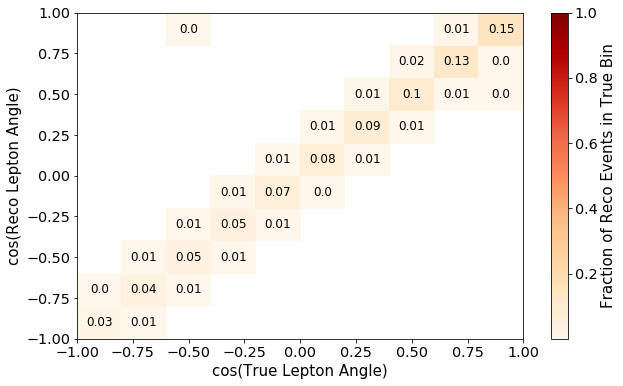

In [41]:
if isCombined == False:
    n_events = nue_nue.shape[0]
    print("n_events here = ", n_events)
    #print("n_events/2 here = ", np.floor(n_events/2))
    print("")
    batch_size = n_events
    #batch_size = int(np.floor(n_events/5))
    #n_events = batch_size

    varss = []
    weightss = []
    labss = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))


    start = 0*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    #sample_set = nue_nue

    #samples = {
        #"nue_nue": nue_nue
     #   "nue_nue": sample_set 
    #}


    current_genie_weights = _get_genie_weight(
                    sample_set, 'cosNu_Angle_Numi_Elec_asmuon', query=SIGNAL_NUE_SEL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


    current_genie_weights2 = _get_genie_weight(
                    sample_set, 'cosNu_Angle_Numi_Elec_asmuon_reco', query=SIGNAL_NUE_SEL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


    current_genie_weights3 = _get_genie_weight(
                    sample_set, 'cosNu_Angle_Numi_Elec_asmuon', query="is_signal == True", track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

    test_list1 = current_genie_weights
    test_list2 = current_genie_weights2

    if len(test_list1) == len(test_list2) and len(test_list1) == sum([1 for i, j in zip(test_list1, test_list2) if i == j]):
        print("All is well.")
    else:
        print("Oh no.")

    bins = np.arange(-1.0, 1.2, 0.2)

    var1 = sample_set.query(SIGNAL_NUE_SEL_QUERY)['cosNu_Angle_Numi_Elec_asmuon']
    weight1 = current_genie_weights * weights["nue_nue"]
    if isRun3 == False and isCombined == False:
        var1.to_csv("nue_full_var1_recoCut_"+ending+".csv")
        np.savetxt("nue_full_weight1_recoCut_"+ending+".csv", 
                    weight1,
                    delimiter =", ", 
                    fmt ='% s')
    if isRun3 == True and isCombined == False:
        var1.to_csv("nue_full_var1_recoCut_run3_"+ending+".csv")
        np.savetxt("nue_full_weights1_recoCut_run3_"+ending+".csv", 
                    weight1,
                    delimiter =", ", 
                    fmt ='% s')
    

    var2 = sample_set.query(SIGNAL_NUE_SEL_QUERY)['cosNu_Angle_Numi_Elec_asmuon_reco']
    weight2 = current_genie_weights2* weights["nue_nue"]
    if isRun3 == False and isCombined == False:
        var2.to_csv("nue_full_var2_recoCut_"+ending+".csv")
        np.savetxt("nue_full_weight2_recoCut_"+ending+".csv", 
                    weight2,
                    delimiter =", ", 
                    fmt ='% s')
    if isRun3 == True and isCombined == False:
        var2.to_csv("nue_full_var2_recoCut_run3_"+ending+".csv")
        np.savetxt("nue_full_weights2_recoCut_run3_"+ending+".csv", 
                    weight2,
                    delimiter =", ", 
                    fmt ='% s')


    var3 = sample_set.query("is_signal == True")['cosNu_Angle_Numi_Elec_asmuon']
    weight3 = current_genie_weights3* weights["nue_nue"]
    if isRun3 == False and isCombined == False:
        var3.to_csv("nue_full_var3_recoCut_"+ending+".csv")
        np.savetxt("nue_full_weight3_recoCut_"+ending+".csv", 
                    weight3,
                    delimiter =", ", 
                    fmt ='% s')
    if isRun3 == True and isCombined == False:
        var3.to_csv("nue_full_var3_recoCut_run3_"+ending+".csv")
        np.savetxt("nue_full_weights3_recoCut_run3_"+ending+".csv", 
                    weight3,
                    delimiter =", ", 
                    fmt ='% s')

    #print(TOTAL_QUERY)

    zerocopysmear = plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=True)

In [42]:
if isCombined == True:
    
    SPLIT = 1
    scaling = 1
    
    pot = 2e20
    nueratio  = pot/2.38181e+22 
    weights_r1 = { 
                "nue_nue"  : nueratio  * SPLIT * scaling
    }
    
    pot =  5.014e20
    nueratio  = pot/2.53486e+22 
    weights_r3 = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }
    

    ###################################
    n_events_r1 = nue_nue_r1.shape[0]
    print("n_events_r1 here = ", n_events_r1)
    #print("n_events/2 here = ", np.floor(n_events_r1/2))
    print("")
    batch_size_r1 = n_events_r1

    print(n_events_r1/batch_size_r1)
    print(int(n_events_r1/batch_size_r1))


    start = 0*batch_size_r1
    if (start + batch_size_r1) < n_events_r1:
        end = start + batch_size_r1
    else:
        end = n_events_r1
    sample_set_r1 = nue_nue_r1.iloc[start:end]
    
    #####
    
    n_events_r3 = nue_nue_r3.shape[0]
    print("n_events_r3 here = ", n_events_r3)
    #print("n_events/2 here = ", np.floor(n_events_r3/2))
    print("")
    batch_size_r3 = n_events_r3

    print(n_events_r3/batch_size_r3)
    print(int(n_events_r3/batch_size_r3))


    start = 0*batch_size_r3
    if (start + batch_size_r3) < n_events_r3:
        end = start + batch_size_r3
    else:
        end = n_events_r3
    sample_set_r3 = nue_nue_r3.iloc[start:end]
    
    #########################################


    current_genie_weights_r1 = _get_genie_weight(
                    sample_set_r1, 'cosNu_Angle_Numi_Elec_asmuon', query=SIGNAL_NUE_SEL_QUERY_R1, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
    current_genie_weights_r3 = _get_genie_weight(
                    sample_set_r3, 'cosNu_Angle_Numi_Elec_asmuon', query=SIGNAL_NUE_SEL_QUERY_R3, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

    current_genie_weights = list(current_genie_weights_r1*weights_r1["nue_nue"]) + list(current_genie_weights_r3*weights_r3["nue_nue"])
    current_genie_weights = np.array(current_genie_weights)
    
    ####

    current_genie_weights2_r1 = _get_genie_weight(
                    sample_set_r1, 'cosNu_Angle_Numi_Elec_asmuon_reco', query=SIGNAL_NUE_SEL_QUERY_R1, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
    current_genie_weights2_r3 = _get_genie_weight(
                    sample_set_r3, 'cosNu_Angle_Numi_Elec_asmuon_reco', query=SIGNAL_NUE_SEL_QUERY_R3, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
    
    current_genie_weights2 = list(current_genie_weights2_r1*weights_r1["nue_nue"]) + list(current_genie_weights2_r3*weights_r3["nue_nue"])
    current_genie_weights2 = np.array(current_genie_weights2)
    
    ####

    current_genie_weights3_r1 = _get_genie_weight(
                    sample_set_r1, 'cosNu_Angle_Numi_Elec_asmuon', query="is_signal == True", track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
    current_genie_weights3_r3 = _get_genie_weight(
                    sample_set_r3, 'cosNu_Angle_Numi_Elec_asmuon', query="is_signal == True", track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

    current_genie_weights3 = list(current_genie_weights3_r1*weights_r1["nue_nue"]) + list(current_genie_weights3_r3*weights_r3["nue_nue"])
    current_genie_weights3 = np.array(current_genie_weights3)
    
    ####
    
    test_list1 = current_genie_weights
    test_list2 = current_genie_weights2

    if len(test_list1) == len(test_list2) and len(test_list1) == sum([1 for i, j in zip(test_list1, test_list2) if i == j]):
        print("All is well.")
    else:
        print("Oh no.")
        
        
    ####

    bins = np.arange(-1.0, 1.2, 0.2)

    var1_r1 = sample_set_r1.query(SIGNAL_NUE_SEL_QUERY_R1)['cosNu_Angle_Numi_Elec_asmuon']
    var1_r3 = sample_set_r3.query(SIGNAL_NUE_SEL_QUERY_R3)['cosNu_Angle_Numi_Elec_asmuon']
    var_temps = [var1_r1, var1_r3]
    var1 = pd.concat(var_temps)
    weight1 = current_genie_weights

    var2_r1 = sample_set_r1.query(SIGNAL_NUE_SEL_QUERY_R1)['cosNu_Angle_Numi_Elec_asmuon_reco']
    var2_r3 = sample_set_r3.query(SIGNAL_NUE_SEL_QUERY_R3)['cosNu_Angle_Numi_Elec_asmuon_reco']
    var_temps = [var2_r1, var2_r3]
    var2 = pd.concat(var_temps)
    weight2 = current_genie_weights2

    var3_r1 = sample_set_r1.query("is_signal == True")['cosNu_Angle_Numi_Elec_asmuon']
    var3_r3 = sample_set_r3.query("is_signal == True")['cosNu_Angle_Numi_Elec_asmuon']
    var_temps = [var3_r1, var3_r3]
    var3 = pd.concat(var_temps)
    weight3 = current_genie_weights3


    zerocopysmear = plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=True)

### Now look at Efficiency

In [49]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, title, savetitle, savetitleplot): 
    
    # generated true signal events per bin 
    gen = plt.hist(var1, bins, weights=weight1, color='deepskyblue')
    plt.close()
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    # compute efficiency
    sel = ax1.hist(var2, bins, weights=weight2, color='white')
    print("sel = ", sel[0])
    print("")
    print("gen = ", gen[0])
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        #eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/ sel[0][i] ) )
        print("In bin", i, ", ", title ," = ", eff[i], " with error = ", eff_err[i])
        
    eff_tot = sum(sel[0])/sum(gen[0])
    print("Total ", title)
    print(eff_tot)
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    ax1.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax1.set_ylim(0, 1)

    #ax1.set_ylabel('Efficiency', fontsize=15)
    #ax1.set_title("Efficiency")
    ax1.set_ylabel(title, fontsize=15)
    ax1.set_title(title)
    ax1.set_xlabel(xaxis)
    
    np.savetxt(savetitle,
           eff,
           delimiter =", ", 
           fmt ='% s')
    
    print("Plot title: ", savetitleplot)
    fig.savefig(savetitleplot,bbox_inches='tight' )

    plt.show()

sel =  [ 0.89060307  1.92055559  2.17370462  3.12207031  5.25687981  6.80241585
 10.11044502 16.89941597 31.2947731  76.7922287 ]

gen =  [ 28.72437859  32.05886841  38.44991302  44.40248871  54.79794312
  69.56930542  93.07192993 136.82666016 229.68109131 568.95928955]
In bin 0 ,  Efficiency  =  0.03100512906937235  with error =  0.032340906580337975
In bin 1 ,  Efficiency  =  0.05990715477318052  with error =  0.041913181316450054
In bin 2 ,  Efficiency  =  0.056533408092970486  with error =  0.037245016078888686
In bin 3 ,  Efficiency  =  0.07031295774875372  with error =  0.03836917102528468
In bin 4 ,  Efficiency  =  0.09593206437445806  with error =  0.03978325374084005
In bin 5 ,  Efficiency  =  0.09777898178972447  with error =  0.0356098702833069
In bin 6 ,  Efficiency  =  0.1086304434646291  with error =  0.03225487143172318
In bin 7 ,  Efficiency  =  0.12350967238804372  with error =  0.0281279891370155
In bin 8 ,  Efficiency  =  0.1362531539862799  with error =  0.022636219

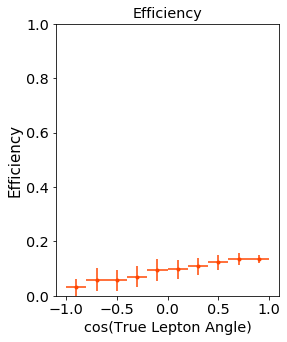

In [50]:
#ENERGY
# Efficiency =  tot_sig_sel/tot_sig
#-----------------------------------------------------------------------------------
##SEL_QUERY + fidq = TOTAL_QUERY
bins = np.arange(-1.0, 1.2, 0.2)
scaling = 1
SPLIT = 1.0

SPLIT = 1
scaling = 1

pot = 2e20
nueratio  = pot/2.38181e+22 
weights_r1 = { 
            "nue_nue"  : nueratio  * SPLIT * scaling
}

pot =  5.014e20
nueratio  = pot/2.53486e+22 
weights_r3 = {
            "nue_nue"  : nueratio  * SPLIT * scaling
}

#current_genie_weights = _get_genie_weight(
#                nue_nue, 'true_e', query=truthsel_nue_only, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

#current_genie_weights2 = _get_genie_weight(
#                nue_nue, 'true_e', query=TOTAL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
######
current_genie_weights_r1 = _get_genie_weight(
                sample_set_r1, 'cosNu_Angle_Numi_Elec_asmuon', query=("is_signal == True"), track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
current_genie_weights_r3 = _get_genie_weight(
                sample_set_r3, 'cosNu_Angle_Numi_Elec_asmuon', query=("is_signal == True"), track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

current_genie_weights = list(current_genie_weights_r1*weights_r1["nue_nue"]) + list(current_genie_weights_r3*weights_r3["nue_nue"])
current_genie_weights = np.array(current_genie_weights)

####

current_genie_weights2_r1 = _get_genie_weight(
                sample_set_r1, 'cosNu_Angle_Numi_Elec_asmuon', query=SIGNAL_NUE_SEL_QUERY_R1, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
current_genie_weights2_r3 = _get_genie_weight(
                sample_set_r3, 'cosNu_Angle_Numi_Elec_asmuon', query=SIGNAL_NUE_SEL_QUERY_R3, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

current_genie_weights2 = list(current_genie_weights2_r1*weights_r1["nue_nue"]) + list(current_genie_weights2_r3*weights_r3["nue_nue"])
current_genie_weights2 = np.array(current_genie_weights2)

####################################

#var1 = nue_nue.query(truthsel_nue_only)['true_e']
#weight1 = current_genie_weights* weights["nue_nue"]

#var2 = nue_nue.query(TOTAL_QUERY)['true_e']
#weight2 = current_genie_weights2 * weights["nue_nue"]

#####

var1_r1 = sample_set_r1.query("is_signal == True")['cosNu_Angle_Numi_Elec_asmuon']
var1_r3 = sample_set_r3.query("is_signal == True")['cosNu_Angle_Numi_Elec_asmuon']
var_temps = [var1_r1, var1_r3]
var1 = pd.concat(var_temps)
weight1 = current_genie_weights

var2_r1 = sample_set_r1.query(SIGNAL_NUE_SEL_QUERY_R1)['cosNu_Angle_Numi_Elec_asmuon']
var2_r3 = sample_set_r3.query(SIGNAL_NUE_SEL_QUERY_R3)['cosNu_Angle_Numi_Elec_asmuon']
var_temps = [var2_r1, var2_r3]
var2 = pd.concat(var_temps)
weight2 = current_genie_weights2


###########################################

variable = 'cosNu_Angle_Numi_Elec_asmuon'
xaxis = "cos(True Lepton Angle)"
savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_angleDiff_matrix_trueeff_"+ending+".csv"
savetitleplot = "batch_eff_nue_fig_full_500_catsel_nopions_angleDiff_matrix_trueeff_"+ending+".svg"

plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, "Efficiency", savetitle, savetitleplot)

In [ ]:
##------------------------------------------------------------------